In [1]:
"""
  A manager that facilitates reading and writing files to GCP Storage
"""
import logging
import os
import subprocess
from io import BytesIO
from typing import List, Dict, Callable, Tuple, Union
from mypy_extensions import TypedDict

from google.cloud import storage # type: ignore

def get_path_prefix(root_dir: str, relative_path: str) -> str:
    prefix = ''
    if root_dir:
        prefix = root_dir.rstrip('/') + '/'

    if relative_path and relative_path != '/':
        prefix = prefix + relative_path.strip('/') + '/'

    return prefix

class PathNode(TypedDict, total=False):
    name: str
    type: str
    size: float
        
class GCPStorageManager(object):

    def __init__(self, storage_details: Dict, verbose: bool) -> None:
        self._bucket_name = storage_details.get('bucket')
        self._root_dir = storage_details.get('root')
        self.client = storage.Client()
        self.verbose = verbose

    def _abs_path(self, rel_path: str) -> str:
        if not self._root_dir:
            return rel_path

        return os.path.join(self._root_dir, rel_path)

    def _build_current_url(self) -> str:
        if self._root_dir:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name + "/" + self._root_dir
        else:
            return "https://console.cloud.google.com/storage/browser/" + self._bucket_name

    def get_root_dir(self) -> str:
        return self._root_dir

    def get_storage_details(self) -> Dict:
        return {
            'provider': file_utils.ProviderList.GCP_STORAGE,
            'bucket': self._bucket_name,
            'root': self._root_dir
        }

    def get_sync_login_command(self, env_vars: Dict) -> List[str]:
        return None

    def get_sync_url(self, path: str) -> str:
        if not path or path == '/':
            abs_path = self._root_dir
        else:
            abs_path = self._abs_path(path)
        return f'gs://{self._bucket_name}/{abs_path}'

    def get_sync_command(self, src_dir: str, remote_path: str) -> Callable:

        def sync_call() -> Tuple[int, str]:
            cmd = ['gsutil', 'rsync', '-r', src_dir, self.get_sync_url(remote_path)]
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = p.communicate()
            err_code = 0
            stderr_val = ''

            if p.returncode != 0:
                logging.error('Copy response is: {}'.format(stderr.decode('utf-8')))
                stderr_val = stderr.decode('utf-8')
                err_code = p.returncode

            return err_code, stderr_val

        return sync_call

    def rm_file(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        path = self._abs_path(relative_path)
        blob = bucket.blob(path)
        logging.info('Deleting file at ' + path)
        blob.delete()

    def rm_dir(self, relative_path: str) -> None:
        bucket = self.client.bucket(self._bucket_name)
        prefix = get_path_prefix(self._root_dir, relative_path)
        blob = bucket.blob(prefix)
        logging.info('Deleting files at ' + prefix)
        blob.delete()

    def read_content(self, path: str, throw_exception: bool, read_range: str = None, streaming: bool = False) -> bytes:
        try:
            path = self._abs_path(path)
            bucket = self.client.bucket(self._bucket_name)
            blob = bucket.blob(path)
            result = blob.download_as_bytes()

            if self.verbose:
                logging.info(f"Downloading content from {self._build_current_url()}/{path}")

            return result
        except Exception as e:
            raise

    #def gen_presigned_url(self, path: str) -> str:
    #    # dask and other frameworks explicit s3 link rather than a byte stream or contet (e.g. s3://bucket/foo.csv)
    #    return self._s3.generate_presigned_url('get_object',
    #                                           Params={'Bucket': self._bucket_name, 'Key': self._abs_path(path)})

    # Checks to see if the job directory exists.  No side-effects.
    def check_dir_exists(self, path: str) -> bool:
        # Create the prefix for this particular job.
        exists = False
        prefix = get_path_prefix(self._root_dir, path)
        blobs = list(self.client.list_blobs(
            self._bucket_name, prefix=prefix
        ))
        if len(blobs) > 0:
            exists = True

        return exists

    def _download_content(self, remote_path: str) -> bytes:
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading content from {self._build_current_url()}/{remote_path}")

        fileobj = BytesIO()
        blob.download_to_file(fileobj)
        return fileobj.getvalue()

    def download_file(self, remote_path: str, file_name: str) -> None:
        # Move references to large data items across folders
        remote_path = self._abs_path(remote_path)
        bucket = self.client.bucket(self._bucket_name)
        blob = bucket.blob(remote_path)
        if self.verbose:
            logging.info(f"Downloading file {self._build_current_url()}/{remote_path} to {file_name}")

        dirname = os.path.dirname(file_name)

        if dirname:
            # Only create a directory if it's not ''
            if not os.path.exists(dirname):
                os.makedirs(dirname)

        blob.download_to_filename(file_name)

    def download_and_unzip(self, remote_path: str, local_dir: str) -> None:
        zip_bytes = self._download_content(remote_path)
        file_utils.unzip_into_dir(zip_bytes, local_dir)

    def download_dir(self, remote_path: str, local_path: str) -> int:
        nFiles = 0
        if self.verbose:
            logging.info("Downloading folder: " + remote_path + " to " + local_path)

        prefix = file_utils.get_path_prefix(self._root_dir, remote_path)
        for blob in self.client.list_blobs(self._bucket_name, prefix=prefix):
            if blob.name.endswith('/'):
                continue

            rel_path = os.path.relpath(blob.name, prefix)
            dest_pathname = os.path.join(local_path, rel_path)

            if not os.path.exists(os.path.dirname(dest_pathname)):
                os.makedirs(os.path.dirname(dest_pathname))

            if self.verbose:
                logging.info(f"Downloading file {blob.name} to {dest_pathname}")

            blob.download_to_filename(dest_pathname)  # Download
            nFiles += 1

        return nFiles

    def upload_content(self, content: bytes, file_name: str) -> None:
        # Uploads file content to a specific filename location
        bucket = self.client.bucket(self._bucket_name)
        if self.verbose:
            logging.info(f"Uploading content to {self._build_current_url()}/{file_name}")

        blob = bucket.blob(self._abs_path(file_name))
        blob.upload_from_file(BytesIO(content))

    def list_directory(self, path: str, with_size: bool = False) -> Dict:
        prefix = get_path_prefix(self._root_dir, path)
        bucket = self.client.bucket(self._bucket_name)
        blobs = bucket.list_blobs(prefix=prefix)
        nodes = []
        for blob in blobs:
            if blob.name.endswith('/'):
                nodes.append(PathNode(name=os.path.basename(blob.name[:-1]), type='folder'))
            else:
                nodes.append(PathNode(name=os.path.basename(blob.name), type='file'))

        return {
            'nodes': nodes
        }


In [2]:
import os

from dotenv import load_dotenv
load_dotenv(verbose=True)

print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

/Users/victoria/dev/flowhub_gcp_credentials.json


In [3]:
manager = GCPStorageManager({
    'bucket': 'partnerships-data-reporting',
    'root': ''
}, verbose=True)

In [4]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [5]:
import json
import pandas as pd
directory_contents = manager.list_directory('')['nodes']

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [6]:
len(directory_contents)

2170

In [7]:
directory_contents[:10]

[{'name': '2XKLNivK7S6gejYxo_customers.csv', 'type': 'file'},
 {'name': '2XKLNivK7S6gejYxo_locations.csv', 'type': 'file'},
 {'name': 'qnRrQ6iFzZr9wHQ6Q_inventory.csv', 'type': 'file'},
 {'name': 'qnRrQ6iFzZr9wHQ6Q_sales.csv', 'type': 'file'},
 {'name': '2a7qeHaHXstn2SAg9_customers.csv', 'type': 'file'},
 {'name': '2a7qeHaHXstn2SAg9_locations.csv', 'type': 'file'},
 {'name': 'fDH93XvoQxvqd3Raq_inventory.csv', 'type': 'file'},
 {'name': 'fDH93XvoQxvqd3Raq_sales.csv', 'type': 'file'},
 {'name': '3EGbFxxKdDKYqygKw_customers.csv', 'type': 'file'},
 {'name': '3EGbFxxKdDKYqygKw_locations.csv', 'type': 'file'}]

In [8]:
company_ids_set = set([])

for file_metadata in directory_contents:
    file_name = file_metadata['name']
    # Company locations file case.
    if '_locations.csv' in file_name:
        company_id = file_name.replace('_locations.csv', '')
        company_ids_set.add(company_id)

company_ids = sorted(list(company_ids_set))
company_ids_count = len(company_ids)
print(f'There are {company_ids_count} companies in the dataset')

There are 172 companies in the dataset


In [9]:
company_location_ids_set = set([])

for index, company_id in enumerate(company_ids_set):
    try:
        locations_csv_string = manager.read_content(f'{company_id}/{company_id}_locations.csv', throw_exception=True)
        locations_io = StringIO(locations_csv_string.decode("utf-8"))
        locations_dataframe = pd.read_csv(locations_io)
        for location_index in locations_dataframe.index:
            location_id = locations_dataframe['locationId'][location_index]
            location_state = locations_dataframe['state'][location_index]
            company_location_ids_set.add((company_id, location_id, location_state))
    except:
        print(f'[{index + 1}] An exception occurred for company ({company_id}, {location_id}, {location_state})')

company_location_ids_count = len(list(company_location_ids_set))
print(f'There are {company_location_ids_count} company locations in the dataset')

[53] An exception occurred for company (5nMPQfwSXPKWoX3yQ, 2t3guxpfanCWqycA6, MA)
[121] An exception occurred for company (guNh9fyGuttgXAXsj, WCXL3HhQzSr6kHaAX, CO)
There are 339 company locations in the dataset


In [10]:
company_location_ids_set

{('2XKLNivK7S6gejYxo', 'qnRrQ6iFzZr9wHQ6Q', 'OR'),
 ('2a7qeHaHXstn2SAg9', 'fDH93XvoQxvqd3Raq', 'CA'),
 ('3EGbFxxKdDKYqygKw', 'dTY2B8G3GjHJEtLB6', 'MA'),
 ('3Zqksvn9wb6dz9sjX', 'eqZW5GzJ3nJ4yWNNY', 'MI'),
 ('4A5DE8Zj5gDtSmCbn', 'JYAZRDbztXRLwJ5r6', 'CO'),
 ('4e6Qfkyei5KkxS56h', 'T96rArAd8eDKX5cKH', 'MI'),
 ('4mtWSXbcCsL23BCiu', 'Dc52HQfFwa2xwhXej', 'CA'),
 ('4xWeGuAg4jDmZSWxA', 'PY9ucfFTZc4XPSuPC', 'CO'),
 ('4xWeGuAg4jDmZSWxA', 'b5KEZ723yYvGdccgv', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'CaNMh4HdcNdPFkoYK', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'YLEEhTz7umoffAPqd', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'bS7R8w9hgETJuiZoj', 'CO'),
 ('6DwQ3xhCWDGBRFFss', 'xiJBqHKLRED7J2vHe', 'CO'),
 ('6K9bzPik9WxNFCceT', 'nMdvN7zKuFLBwkye7', 'OR'),
 ('6YRM2orTfSySDKhLL', 'R5EZkhoLBF9e7qxmF', 'MA'),
 ('7Grxab9AL8HbnNcCn', 'J4qscTeHW28gWBxju', 'CO'),
 ('7K2zgvXcNGQ5nKWox', '8d7i9vhsNpy6RxZMb', 'MI'),
 ('7R5MBJ2wAH328M9P7', 'YmCZQD9MS5SLdc3AF', 'MI'),
 ('7R5MBJ2wAH328M9P7', 'kYM3JYW6yPzhuu8tE', 'MI'),
 ('7SRQ7Z7xuN5EGXGSu', 'JDcPyy6

In [12]:
# (company_id, location_id, location_sales_dataframe)
company_location_dataframes = []

# for index, company_location_tuple in enumerate(list([('4A5DE8Zj5gDtSmCbn', 'JYAZRDbztXRLwJ5r6', 'CO')])):
for index, company_location_tuple in enumerate(list(company_location_ids_set)):
    company_id, location_id, location_state = company_location_tuple
    print(f'[{index + 1}] Downloading dataframes for location ({company_id}, {location_state})')

    try:
        location_sales_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
        location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
        location_sales_dataframe = pd.read_csv(location_sales_io)
        
        location_inventory_csv_string = manager.read_content(f'{company_id}/{location_id}/{location_id}_inventory.csv', throw_exception=True)
        location_inventory_io = StringIO(location_inventory_csv_string.decode("utf-8"))
        location_inventory_dataframe = pd.read_csv(location_inventory_io)

        company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe))
    except:
        print(f'[{index + 1}] An exception occurred for location ({company_id}, {location_id}, {location_state}) for default path, trying FirstRunWithColorado/ path...')
        try:
            location_sales_csv_string = manager.read_content(f'/FirstRunWithColorado/{company_id}/{location_id}/{location_id}_sales.csv', throw_exception=True)
            location_sales_io = StringIO(location_sales_csv_string.decode("utf-8"))
            location_sales_dataframe = pd.read_csv(location_sales_io)

            location_inventory_csv_string = manager.read_content(f'/FirstRunWithColorado/{company_id}/{location_id}/{location_id}_inventory.csv', throw_exception=True)
            location_inventory_io = StringIO(location_inventory_csv_string.decode("utf-8"))
            location_inventory_dataframe = pd.read_csv(location_inventory_io)

            company_location_dataframes.append((company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe))
        except:
            print(f'[{index + 1}] An exception occurred for company ({company_id}, {location_id}, {location_state}) for both paths, skipping...')

company_location_dataframes_count = len(list(company_location_dataframes))
print(f'There are {company_location_dataframes_count} company location dataframes in the dataset')

[1] Downloading dataframes for location (d7u39ZjnznjCCE54L, CO)
[2] Downloading dataframes for location (gmAmheWQLfWvhg7aF, CO)
[3] Downloading dataframes for location (rrCXhvarvXo7P2fGo, OR)


/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[4] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[5] Downloading dataframes for location (cQSMru9us42nCJKZa, MI)
[6] Downloading dataframes for location (8fkcBjcmScuidkvn2, OR)
[7] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[8] Downloading dataframes for location (jfD4EGaLur6xsEHbQ, CA)
[9] Downloading dataframes for location (4mtWSXbcCsL23BCiu, CA)
[10] Downloading dataframes for location (gmAmheWQLfWvhg7aF, CO)
[11] Downloading dataframes for location (dPBnHGGKDN7BoewSb, CO)
[12] Downloading dataframes for location (cCkcFvmPtcSDHDQJf, CA)
[13] Downloading dataframes for location (s4fnrie58B29225jc, MI)
[14] Downloading dataframes for location (SPYsqAwk5XEjp9ZwX, MI)
[15] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[16] Downloading dataframes for location (9aGAdAw3tYQ4MxCBc, CO)
[17] Downloading dataframes for location (j7MWhCyfRAgZstQdE, CO)
[18] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[19] Downloading dataframes for

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[22] Downloading dataframes for location (rK3atC7axuLcz3iRB, OR)
[23] Downloading dataframes for location (iJscrRfw6uYjEhEKo, CO)
[24] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[25] Downloading dataframes for location (jfD4EGaLur6xsEHbQ, CA)
[26] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[27] Downloading dataframes for location (E2ZWysfDHW2pqB7JW, CO)
[28] Downloading dataframes for location (RgxwCKYJJD3ncZAhe, CA)
[29] Downloading dataframes for location (PsEjmyLevjsT9ExDY, MA)
[30] Downloading dataframes for location (JkTGpPrHTTR3SPGvF, MI)
[31] Downloading dataframes for location (cSnsbv7ccTEXcHAbW, OR)
[32] Downloading dataframes for location (czyNjjNhCHky7mjfu, MI)
[33] Downloading dataframes for location (xk2bRZqMw3RNaxm2g, MI)
[34] Downloading dataframes for location (my6fhmSxAxbdFvBKm, MI)
[35] Downloading dataframes for location (rPXmTTcY4LXmgmTcG, OR)
[36] Downloading dataframes for location (wAcmr4LCaqm2w6LPx, CO)
[37] Downloading datafram

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[40] Downloading dataframes for location (P63pMT9HvTtdmhWcL, MI)
[41] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[42] Downloading dataframes for location (KkyhzzHqgJDFWPM9n, CA)
[43] Downloading dataframes for location (jkCQRyN2bF8EWqbnf, MI)
[44] Downloading dataframes for location (FeYB32454Az4yNvon, CO)
[45] Downloading dataframes for location (caH9RMynqjrmihrxA, CO)
[46] Downloading dataframes for location (ytJJkiN7w4eA5Tguv, CA)
[47] Downloading dataframes for location (hcLfFhKstdmNNtBjx, CO)
[48] Downloading dataframes for location (o46tyNKeC4xHZeh7h, CO)
[49] Downloading dataframes for location (8fkcBjcmScuidkvn2, OR)
[50] Downloading dataframes for location (GNPWTqYqZsfcAA6Jb, CO)
[51] Downloading dataframes for location (aC3Zrhyznpk3pEPQB, MI)
[52] Downloading dataframes for location (qjxySovYhadMBtQTP, MI)
[53] Downloading dataframes for location (L7ME43C6TAoYv6HCb, MA)
[54] Downloading dataframes for location (jXQzYY9rsss3mHoFw, CA)
[55] Downloading datafram

[166] Downloading dataframes for location (RqokibKjt6ueZK52s, CO)
[167] Downloading dataframes for location (3EGbFxxKdDKYqygKw, MA)
[168] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[169] Downloading dataframes for location (GnFCdPCTJTqhBa5bm, MI)
[170] Downloading dataframes for location (EHYBJyTX2dd8CaBeL, MA)
[171] Downloading dataframes for location (m2MJWxTAKTWuRzfPh, MI)
[172] Downloading dataframes for location (RgxwCKYJJD3ncZAhe, CA)
[173] Downloading dataframes for location (cJfeY8ejosCbgzjMB, OR)
[174] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[175] Downloading dataframes for location (E2ZWysfDHW2pqB7JW, CO)
[176] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[177] Downloading dataframes for location (LzvWGesZNXbYjfTKC, OR)
[178] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[179] Downloading dataframes for location (s4fnrie58B29225jc, MI)
[180] Downloading dataframes for location (dPBnHGGKDN7BoewSb, CO)
[181] Down

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,14,24,27,28,38,43,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[183] Downloading dataframes for location (XQak5YK9eZfXYhKgJ, OR)
[184] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[185] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[186] Downloading dataframes for location (pLfKsgDrL9LKFJ5vj, MI)
[187] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[188] Downloading dataframes for location (jfD4EGaLur6xsEHbQ, CA)
[189] Downloading dataframes for location (ByCLyAjbSNLZFD4pc, CO)
[190] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[191] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[192] Downloading dataframes for location (d2Q3Ga3jxiBpsHdHe, MI)
[193] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[194] Downloading dataframes for location (xzFiTkNBmYwLHNLcn, OR)
[195] Downloading dataframes for location (kKBqnAwywSrKLGQpk, OR)
[196] Downloading dataframes for location (sKC85mWeESfBtvGFu, OR)
[197] Downloading dataframes for location (h6ta6GrFvBsTEyoEC, CA)
[198] Down

[300] Downloading dataframes for location (dzTtcES69FJK888SC, OR)
[301] Downloading dataframes for location (HexjEZWy6f7vEeTMT, OR)
[302] Downloading dataframes for location (xk2bRZqMw3RNaxm2g, MI)
[303] Downloading dataframes for location (MRmiGXv584QfQL5pp, OR)
[304] Downloading dataframes for location (PsEjmyLevjsT9ExDY, MA)
[305] Downloading dataframes for location (SPYsqAwk5XEjp9ZwX, MI)
[306] Downloading dataframes for location (rgNDsz626CTLnd53Y, CO)
[307] Downloading dataframes for location (7SRQ7Z7xuN5EGXGSu, CA)
[308] Downloading dataframes for location (jnwGyxTojW8qZkaNq, OR)
[309] Downloading dataframes for location (cJfeY8ejosCbgzjMB, OR)
[310] Downloading dataframes for location (ScA2tJQp3iryzrBKS, CO)
[311] Downloading dataframes for location (2a7qeHaHXstn2SAg9, CA)
[312] Downloading dataframes for location (7yxgKNbqd5PMNzX3P, CA)
[313] Downloading dataframes for location (dbhjfjAkBf2xnrPDK, CO)
[314] Downloading dataframes for location (NdvsZACyTb6HHHz5e, CA)
[315] Down

In [13]:
state_to_count = {}

for company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe in company_location_dataframes:
    # TODO: do data science stuff on these dataframes.
#     print(company_id, location_id, location_state, location_sales_dataframe.shape)
    if location_state not in state_to_count:
        state_to_count[location_state] = 0
    state_to_count[location_state] += 1

state_to_count

{'CO': 98, 'OR': 105, 'MI': 67, 'CA': 48, 'MA': 16, 'AL': 2, 'AZ': 1}

In [14]:
for index, company_location_dataframe_tuple in enumerate(company_location_dataframes):
    company_id, location_id, location_state, location_sales_dataframe, location_inventory_dataframe = company_location_dataframe_tuple
    print(index, company_id, location_id, location_state, location_sales_dataframe.shape, location_inventory_dataframe.shape)

0 d7u39ZjnznjCCE54L eYoBctQZTqsmydrHY CO (47922, 35) (469, 70)
1 gmAmheWQLfWvhg7aF p5YBJDMCPA7PcwEDA CO (148091, 35) (949, 70)
2 rrCXhvarvXo7P2fGo g63EjGYZsjHPqyPL4 OR (18367, 35) (234, 70)
3 HexjEZWy6f7vEeTMT sfaqG9ujHRuML6J2c OR (7187, 35) (806, 69)
4 cQSMru9us42nCJKZa fwodsfJSMPP7D7esX MI (72929, 35) (1053, 70)
5 8fkcBjcmScuidkvn2 MuirNe829ZExjNmek OR (199758, 35) (1848, 70)
6 LzvWGesZNXbYjfTKC Z8HuuuxXkSqbBjy65 OR (66640, 35) (661, 70)
7 jfD4EGaLur6xsEHbQ dRuDEyZkyY4YsToMD CA (21801, 35) (481, 69)
8 4mtWSXbcCsL23BCiu Dc52HQfFwa2xwhXej CA (159792, 35) (1943, 69)
9 gmAmheWQLfWvhg7aF rAffv9HziBbzRzqh3 CO (489915, 35) (1546, 70)
10 dPBnHGGKDN7BoewSb GquEcaJjTtznA2SNW CO (40828, 35) (567, 70)
11 cCkcFvmPtcSDHDQJf vgiY25zfgArEuWhMM CA (103626, 35) (601, 69)
12 s4fnrie58B29225jc wBbhHYEDp52BowBXg MI (145751, 35) (1852, 70)
13 SPYsqAwk5XEjp9ZwX CtuShNA5sgy8GnxMf MI (38781, 35) (1332, 69)
14 LzvWGesZNXbYjfTKC Jrp8Yk9a8jEtf6zRB OR (48225, 35) (328, 70)
15 9aGAdAw3tYQ4MxCBc mBaukdLE4GfLJHMk3 

In [76]:
company_location_dataframes[7][3]

,Unnamed: 0,saleId,itemId,createdAt,updatedAt,clientId,locationId,customerType,orderType,orderSource,voided,totalFeesInDollars,sku,category,brand,productName,strainName,reportUOM,productType,totalTaxInDollars,subtotalInDollars,itemTotalInDollars,costInDollars,costPerGramInDollars,title1,title2,totalGramsSold,numberOfItems,DiscountAmountInDollars,meanSubtotalInDollars,meanCostInDollars,meanCostPerGramInDollars,meanNumberOfItemsSold,meanProfit,meanProfitBulk
0,0,bP5pueRtegziykBqY2EUj3,SC7CkDai6oRijMHLs,2022-04-04 00:57:23.297000+00:00,2022-04-04 00:57:23.297000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,xWdnPrx7Qx,Concentrate,Big Chief,Big Chief Blackwater OG 1g,NaN,Each,Cartridge,5.70,14.31,20.01,8.5,NaN,Big Chief Blackwater OG 1g,Big Chief,1.0,1.0,NaN,14.31,8.5,NaN,1.0,5.81,NaN
1,1,41G94f1GAkSSSSBb7dkGDm,SC7CkDai6oRijMHLs,2022-04-03 21:26:41.039000+00:00,2022-04-03 21:26:41.039000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,xWdnPrx7Qx,Concentrate,Big Chief,Big Chief Blackwater OG 1g,NaN,Each,Cartridge,5.70,14.31,20.01,8.5,NaN,Big Chief Blackwater OG 1g,Big Chief,1.0,1.0,NaN,14.31,8.5,NaN,1.0,5.81,NaN
2,2,3uLT5YqeDixX9YGDWNVwXB,SC7CkDai6oRijMHLs,2022-04-03 19:07:51.999000+00:00,2022-04-03 19:07:51.999000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,xWdnPrx7Qx,Concentrate,Big Chief,Big Chief Blackwater OG 1g,NaN,Each,Cartridge,5.70,14.31,20.01,8.5,NaN,Big Chief Blackwater OG 1g,Big Chief,1.0,1.0,NaN,14.31,8.5,NaN,1.0,5.81,NaN
3,3,fu7Nfy5RzxTchdH7eQV7mR,SC7CkDai6oRijMHLs,2022-04-02 20:16:40.994000+00:00,2022-04-02 20:16:40.994000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,xWdnPrx7Qx,Concentrate,Big Chief,Big Chief Blackwater OG 1g,NaN,Each,Cartridge,5.70,14.31,20.01,8.5,NaN,Big Chief Blackwater OG 1g,Big Chief,1.0,1.0,NaN,14.31,8.5,NaN,1.0,5.81,NaN
4,4,7w2D5P4RB8SFVtZnQkhKY5,SC7CkDai6oRijMHLs,2022-04-02 03:52:58.662000+00:00,2022-04-02 03:52:58.662000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,xWdnPrx7Qx,Concentrate,Big Chief,Big Chief Blackwater OG 1g,NaN,Each,Cartridge,5.70,14.31,20.01,8.5,NaN,Big Chief Blackwater OG 1g,Big Chief,1.0,1.0,NaN,14.31,8.5,NaN,1.0,5.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21796,21796,cn66Q8s91chBhpXxsAWnR6,gC2BkFSfiGajPCcrYJ1P,2021-01-01 21:52:35.446000+00:00,2021-01-01 21:52:35.446000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,Gx8WfF75KE,Concentrate,STIIIZY,Stiiizy King Louis XIII Indica .5g,None,Each,Cartridge,7.79,22.21,30.00,10.0,0.0,Stiiizy King Louis XIII Indica .5g,STIIIZY,0.5,1.0,NaN,22.21,10.0,0.0,1.0,12.21,22.21
21797,21797,95pbkwGzTPQpcbRd5NFSzd,Guwbk4xSu46iVxmrk898,2021-01-01 21:40:17.669000+00:00,2021-01-01 21:40:17.669000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,R8CSqdGkWF,Concentrate,Stiiizy,Stiiizy Blue Burst Hybrid .5g,None,Each,Cartridge,7.79,22.21,30.00,10.0,0.0,Stiiizy Blue Burst Hybrid .5g,Stiiizy,0.5,1.0,NaN,22.21,10.0,0.0,1.0,12.21,22.21
21798,21798,vnqbHZ6Q912nYfFTtvjzNx,ZpEq5h9wOjrbZsKBUOb4,2021-01-01 20:53:10.699000+00:00,2021-01-01 20:53:10.699000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,rKTYmCph4a,PackedBud,Josh D,Josh D OGKS 3.5g | Eighths,Josh D OGKS 3.5g,Grams,None,6.59,16.34,22.93,10.0,0.0,Josh D OGKS 3.5g,Eighths,3.5,1.0,NaN,16.34,10.0,0.0,1.0,6.34,16.34
21799,21799,sc3qVsFSzZbpkeAe1JnbH5,c4pZ4IB5AE24ZLnD0phU,2021-01-01 18:54:25.467000+00:00,2021-01-01 18:54:25.467000+00:00,jfD4EGaLur6xsEHbQ,dRuDEyZkyY4YsToMD,recCustomer,in-store,NaN,False,0.0,rKTYmCph4a,PackedBud,Josh D,Josh D OGKS 3.5g | Eighths,Josh D OGKS 3.5g,Grams,None,6.59,16.34,22.93,10.0,0.0,Josh D OGKS 3.5g,Eighths,3.5,1.0,NaN,16.34,10.0,0.0,1.0,6.34,16.34


# PROCESS DATA FRAMES

In [15]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
pd.set_option("display.max_columns", None)


In [16]:
def pre_process_df(df,loc_id,loc_state):
    df = (
        df
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        .replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    #exclude category = Accessory
    #df_accessory = df_non_high_cost[df_non_high_cost['category'] == 'Accessory']
    #df_non_accessory = df_non_high_cost[(df_non_high_cost['category'] != 'Accessory')]
    #perc_accessory = df_accessory.shape[0] / df_non_high_cost.shape[0]
    # cogs
    cogs = df_non_high_sale[['year_month','subtotalInDollars','costInDollars']].groupby('year_month').sum()
    #
    cogs['subtotalInDollars_after_tax'] = cogs['subtotalInDollars'] * 1.15
    cogs['profit'] = cogs['subtotalInDollars'] - cogs['costInDollars']
    #
    cogs['profit_after_tax'] = cogs['subtotalInDollars_after_tax'] - cogs['costInDollars']
    cogs['margin_perc'] = cogs['profit'] / cogs['subtotalInDollars']
    #
    cogs['margin_perc_after_tax'] = cogs['profit_after_tax'] / cogs['subtotalInDollars_after_tax']
    cogs['location_id'] = loc_id
    cogs['location_state'] = loc_state
    return cogs.reset_index(),perc_low_cost,perc_high_sale,perc_high_cost
    

In [17]:
res = []
low_cost_trim_perc= []
high_sale_trim_perc = []
high_cost_perc = []
for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        low_cost_trim_perc.append(np.nan)
        high_sale_trim_perc.append(np.nan)
        high_cost_perc.append(np.nan)
        continue
    res.append(pre_process_df(df, location_id, location_state)[0])
    low_cost_trim_perc.append(pre_process_df(df, location_id, location_state)[1])
    high_sale_trim_perc.append(pre_process_df(df, location_id, location_state)[2])
    high_cost_perc.append(pre_process_df(df, location_id, location_state)[3])

100%|██████████| 337/337 [18:43<00:00,  3.33s/it]


In [18]:
low_cost_trim_perc_df = pd.DataFrame(low_cost_trim_perc)
low_cost_trim_perc_df.columns = ['low_cost_trim_perc']
high_sale_trim_perc_df = pd.DataFrame(high_sale_trim_perc)
high_sale_trim_perc_df.columns = ['high_sale_trim_perc']
high_cost_trim_perc_df = pd.DataFrame(high_cost_perc)
high_cost_trim_perc_df.columns = ['high_cost_trim_perc']

In [19]:
low_cost_trim_perc_df.describe()

,low_cost_trim_perc
count,309.000000
mean,0.089340
std,0.138269
min,0.000000
25%,0.015852
50%,0.043148
75%,0.101866
max,0.992683


In [20]:
high_sale_trim_perc_df.describe()

,high_sale_trim_perc
count,309.000000
mean,0.000543
std,0.003083
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000021
max,0.036719


In [21]:
high_cost_trim_perc_df.describe()

,high_cost_trim_perc
count,309.000000
mean,0.000123
std,0.000456
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000014
max,0.004920


In [22]:
final_df = pd.concat(res).reset_index(drop=True)

In [23]:
final_df

,year_month,subtotalInDollars,costInDollars,subtotalInDollars_after_tax,profit,profit_after_tax,margin_perc,margin_perc_after_tax,location_id,location_state
0,2021-01,132144.78,43288.63,151966.4970,88856.15,108677.8670,0.672415,0.715144,eYoBctQZTqsmydrHY,CO
1,2021-02,91607.59,28435.66,105348.7285,63171.93,76913.0685,0.689593,0.730081,eYoBctQZTqsmydrHY,CO
2,2021-03,121792.55,30728.13,140061.4325,91064.42,109333.3025,0.747701,0.780610,eYoBctQZTqsmydrHY,CO
3,2021-04,122546.01,31582.27,140927.9115,90963.74,109345.6415,0.742282,0.775898,eYoBctQZTqsmydrHY,CO
4,2021-05,104393.79,22591.68,120052.8585,81802.11,97461.1785,0.783592,0.811819,eYoBctQZTqsmydrHY,CO
...,...,...,...,...,...,...,...,...,...,...
4063,2021-12,150046.43,75786.56,172553.3945,74259.87,96766.8345,0.494913,0.560794,ZvfRr674sQivsWR89,CA
4064,2022-01,142854.36,71637.50,164282.5140,71216.86,92645.0140,0.498528,0.563937,ZvfRr674sQivsWR89,CA
4065,2022-02,141330.82,66388.32,162530.4430,74942.50,96142.1230,0.530263,0.591533,ZvfRr674sQivsWR89,CA
4066,2022-03,157021.34,75936.91,180574.5410,81084.43,104637.6310,0.516391,0.579471,ZvfRr674sQivsWR89,CA


In [ ]:
#final_df_trim = final_df[(final_df['margin_perc'] > 0.2)&(final_df['location_state'] != 'AZ')&(final_df['margin_perc'] < 0.8)]

In [37]:
final_df['margin_final'] = final_df.apply(lambda row: row['margin_perc_after_tax'] if row['location_state'] == 'CA' else row['margin_perc'], axis=1)
final_df=final_df[final_df['location_state'] != 'AZ']



In [74]:
#final_df.to_csv('flowhub_location_analysis_0411.csv')

## Count

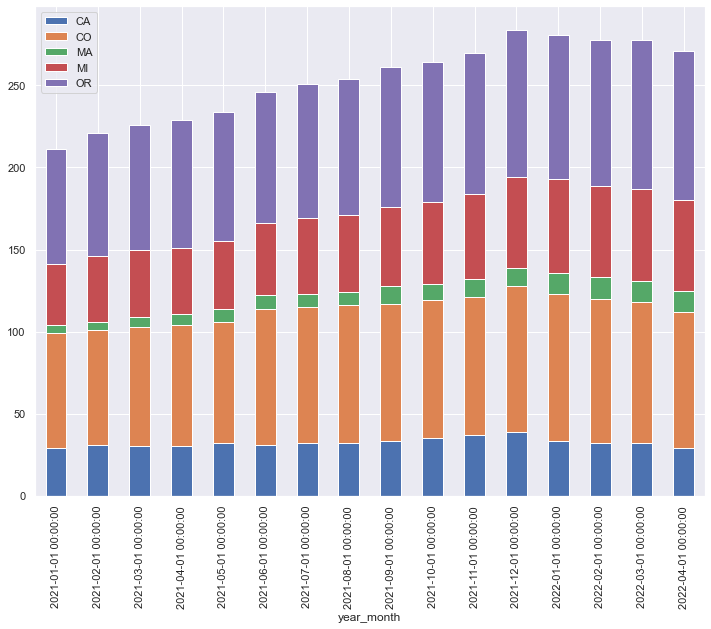

In [39]:
state_count = final_df[['location_state','location_id','year_month']].groupby(['location_state','year_month']).count().unstack().T.reset_index()
state_count.index = pd.to_datetime(state_count['year_month'])

ax = state_count.plot(kind='bar', stacked=True,figsize = (12,9))
ax.legend(loc = 2)

# Distribution of margin by states

In [40]:
# distribution of margin
margin_distr = final_df.groupby(['location_state','year_month'])['margin_perc'].describe().reset_index()
margin_distr['year_month'] = pd.to_datetime(margin_distr['year_month'])

In [41]:
# # distribution of margin
# margin_distr_trim = final_df_trim.groupby(['location_state','year_month'])['margin_perc'].describe().reset_index()
# margin_distr_trim['year_month'] = pd.to_datetime(margin_distr_trim['year_month'])

In [42]:
# distribution of margin afte tax
margin_distr_after_tax = final_df.groupby(['location_state','year_month'])['margin_final'].describe().reset_index()
margin_distr_after_tax['year_month'] = pd.to_datetime(margin_distr_after_tax['year_month'])

In [83]:
#margin_distr.to_csv('flowhub_pre_tax_margin_distribution_0411.csv')
#margin_distr_after_tax.to_csv('flowhub_post_tax_margin_distribution_0411.csv')

## MIN & MAX

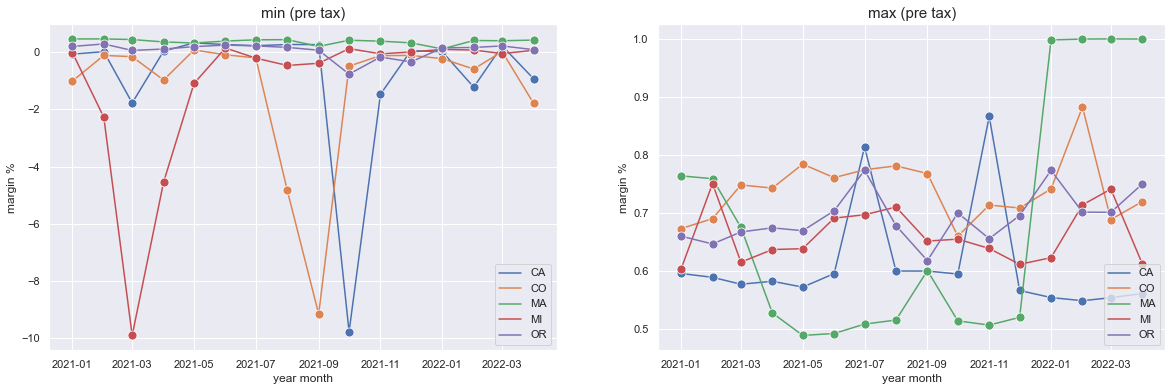

In [86]:
# pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="min", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min (pre tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="max", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("max (pre tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


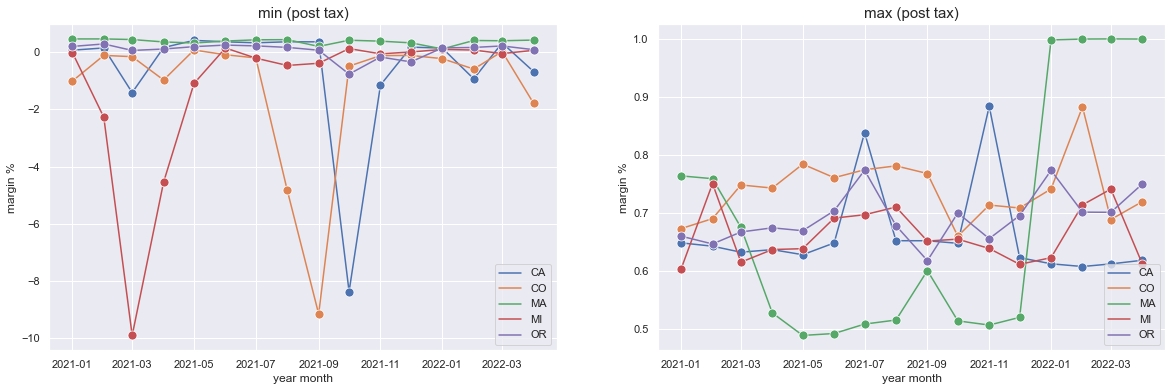

In [89]:
# trimmed after tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="min", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min (post tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
#ax[0].set(ylim=(-0.1, 1))
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="max", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("max (post tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0, 1.1))
sns.set(rc={'figure.figsize':(20,6)})


## MEAN & MED

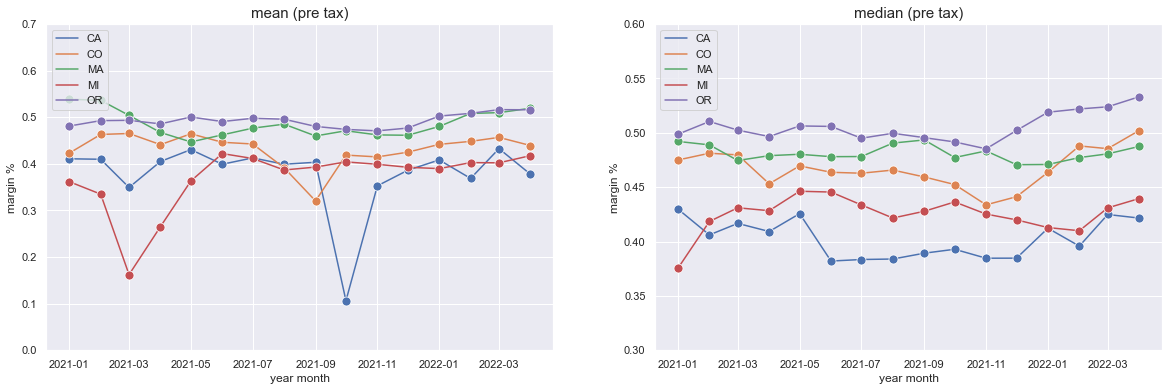

In [87]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(data=margin_distr, x="year_month", y="mean", hue="location_state",marker= 'o', markersize=9,ax=ax[0])

ax[0].set_title("mean (pre tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
ax[0].set(ylim=(0, 0.7))
ax[0].legend(loc = 2)
sns.lineplot(data=margin_distr, x="year_month", y="50%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])

ax[1].set_title("median (pre tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
ax[1].set(ylim=(0.3, 0.6))
ax[1].legend(loc = 2)



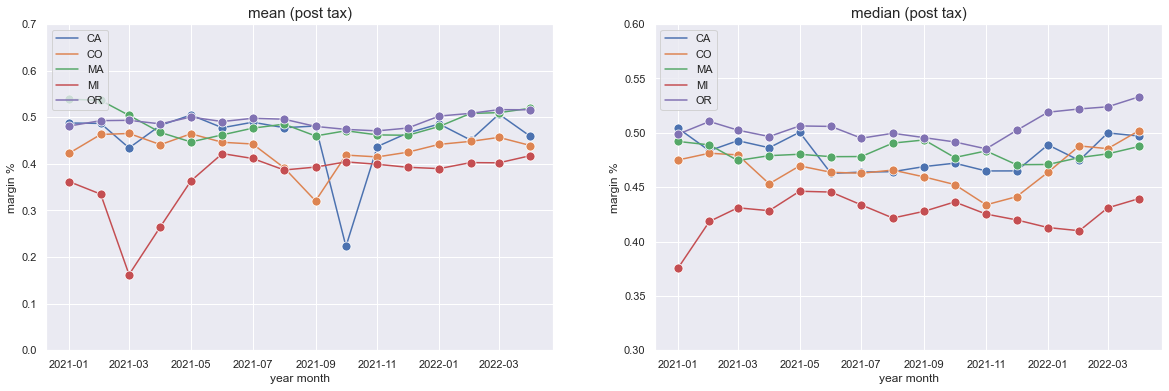

In [90]:
# trimmed after tax
fig, ax =plt.subplots(1,2)
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="mean", hue="location_state",marker= 'o', markersize=9,ax=ax[0])

ax[0].set_title("mean (post tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
ax[0].set(ylim=(0, 0.7))
ax[0].legend(loc = 2)
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="50%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])

ax[1].set_title("median (post tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
ax[1].set(ylim=(0.3, 0.6))
ax[1].legend(loc = 2)



## 25 & 75

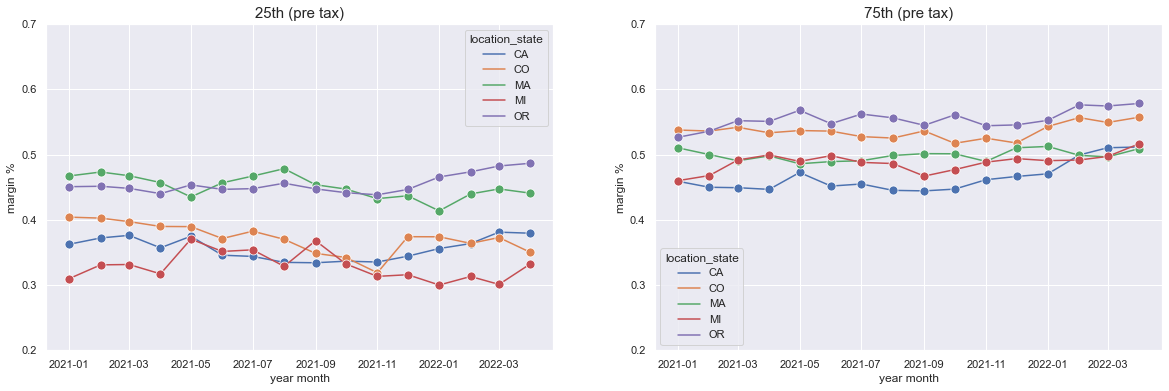

In [88]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="year_month", y="25%", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].set(ylim=(0.2, 0.7))
ax[0].set_title("25th (pre tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="year_month", y="75%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].set(ylim=(0.2, 0.7))
ax[1].set_title("75th (pre tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


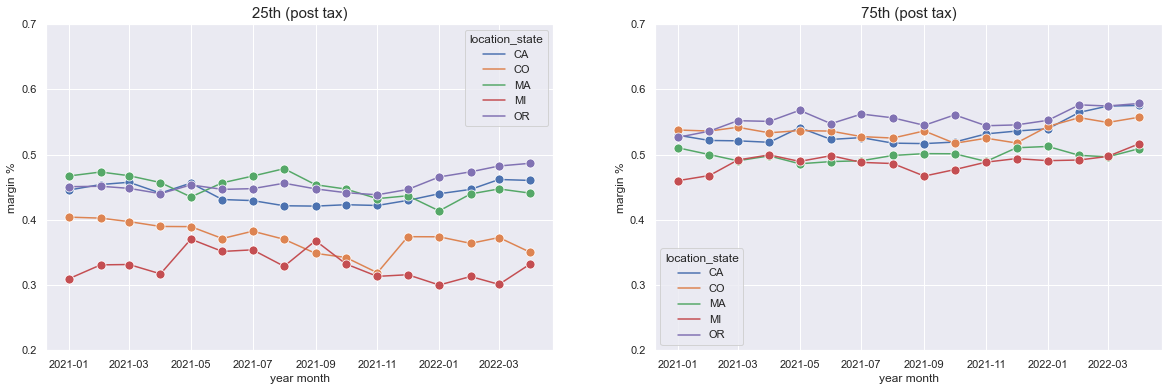

In [91]:
# trimmed after tax
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="25%", hue="location_state",marker= 'o', markersize=9,ax=ax[0])
ax[0].set(ylim=(0.2, 0.7))
ax[0].set_title("25th (post tax)", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr_after_tax, x="year_month", y="75%", hue="location_state",marker= 'o', markersize=9,ax=ax[1])
ax[1].set(ylim=(0.2, 0.7))
ax[1].set_title("75th (post tax)", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
sns.set(rc={'figure.figsize':(20,6)})


# Inventory

In [54]:
def pre_process_inv_df(df_inv,loc_id,loc_state):
    if 'costPerGram' in df_inv.columns:
        df_inv_to_merge = df_inv[['sku','quantity','cost','costPerGram']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost'].fillna(df_['costPerGram'])})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
    else:
        df_inv_to_merge = df_inv[['sku','quantity','cost']]
        df_inv_to_merge = df_inv_to_merge.assign(**{"cost_final": lambda df_: df_['cost']})
        #set unit to dollar
        df_inv_to_merge['cost_final'] = df_inv_to_merge['cost_final'] / 100
        
    # get each SKU's medium cost price across all inventory entries
    med_sku_price = df_inv_to_merge[['sku','cost_final']].groupby(['sku']).median().reset_index()
    # trim high cost items
    df_non_high_cost =  med_sku_price[med_sku_price['cost_final'] <= 500]

    # get each SKU's total quantity
    total_sku_quantity = df_inv_to_merge[['sku','quantity']].groupby(['sku']).sum().reset_index()
    total_sku_quantity_trim = total_sku_quantity[total_sku_quantity['quantity'] <= 10000]
    # calculate inventory
    total_inv_df = df_non_high_cost.merge(total_sku_quantity_trim,on = 'sku',how = 'inner')
    #calculate coverage
    num_sku = total_inv_df.shape[0]
    coverage = total_inv_df.shape[0] / df_inv_to_merge['sku'].nunique()
    non_zero_cost_perc = 1- ((total_inv_df[(total_inv_df['cost_final'] == 0)].shape[0]) / total_inv_df.shape[0])
    inventory = np.nansum(total_inv_df['quantity'] * total_inv_df['cost_final'])
    final_df = pd.DataFrame([loc_id,loc_state,inventory,num_sku,coverage,non_zero_cost_perc]).T
    return final_df
    

In [59]:
inv_res = []
for company_id, location_id, location_state, sa_df, inv_df in tqdm(company_location_dataframes):
    if len(sa_df) == 0 or len(inv_df) == 0:
        continue
    inv_res.append(pre_process_inv_df(inv_df, location_id, location_state))
    

100%|██████████| 337/337 [00:01<00:00, 260.09it/s]


In [60]:
inv_res_df = pd.concat(inv_res).reset_index(drop=True)
inv_res_df.columns = ['loc_id','loc_state','inventory','num_sku_in_inventory','coverage','non_zero_cost_perc']

In [61]:
inv_res_df['inventory'] = inv_res_df['inventory'].astype('float')
inv_res_df['num_sku_in_inventory'] = inv_res_df['num_sku_in_inventory'].astype('float')
inv_res_df['coverage'] = inv_res_df['coverage'].astype('float')
inv_res_df['non_zero_cost_perc'] = inv_res_df['non_zero_cost_perc'].astype('float')

In [62]:
inv_res_df.describe()


,inventory,num_sku_in_inventory,coverage,non_zero_cost_perc
count,3.080000e+02,308.000000,308.000000,308.000000
mean,1.988527e+05,895.308442,0.999704,0.985974
std,2.462787e+05,809.862444,0.001144,0.045516
min,6.301000e+02,18.000000,0.990542,0.616438
25%,6.684033e+04,446.000000,1.000000,0.998386
50%,1.032484e+05,722.000000,1.000000,1.000000
75%,2.301217e+05,1085.000000,1.000000,1.000000
max,1.914817e+06,7395.000000,1.000000,1.000000


In [79]:
#inv_res_df.to_csv('flowhub_location_inventory_0411.csv')

# inventory TO

In [64]:
def calculate_inventory_to(inv_df,cogs_df):
    cogs_3m = cogs_df[cogs_df['year_month'].isin(['2022-01','2022-02','2022-03'])]
    loc_cogs_3m_df = cogs_3m[['costInDollars','location_id']].groupby(['location_id']).sum().reset_index()
    loc_cogs_3m_df.columns = ['loc_id','costInDollars']
    inventory_df_joined = loc_cogs_3m_df.merge(inv_res_df,on = 'loc_id',how = 'inner')
    inventory_df_joined['to'] = inventory_df_joined['costInDollars'] / inventory_df_joined['inventory'] * 4
    return inventory_df_joined

In [65]:
to_df = calculate_inventory_to(inv_res_df,final_df)

In [84]:
#to_df.to_csv('flowhub_location_inventory_TO_0411.csv')

In [67]:
# distribution of margin
to_distr = to_df.groupby(['loc_state'])['to'].describe().reset_index()
coverage_distr = to_df.groupby(['loc_state'])['non_zero_cost_perc'].describe().reset_index()

In [85]:
#to_distr.to_csv('flowhub_inv_TO_distribution_0411.csv')

Text(0, 0.5, 'inventory TO')

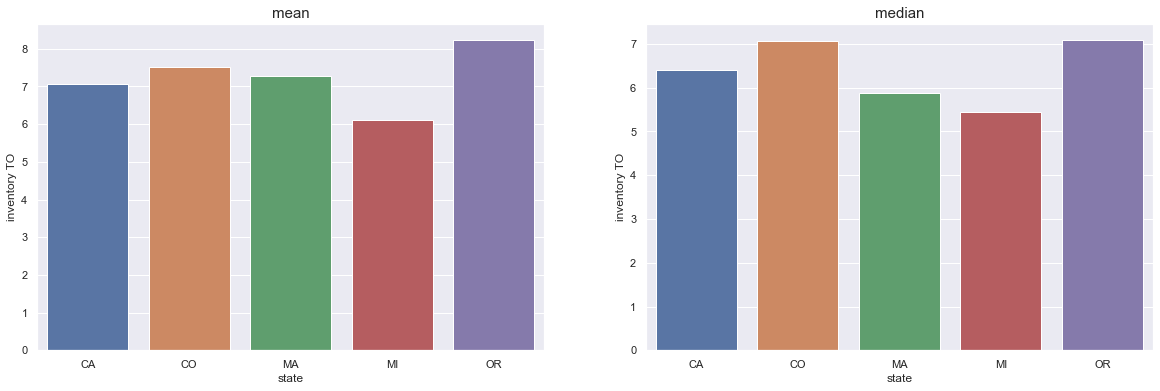

In [68]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="mean",ax=ax[0])

ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="50%",ax=ax[1])

ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

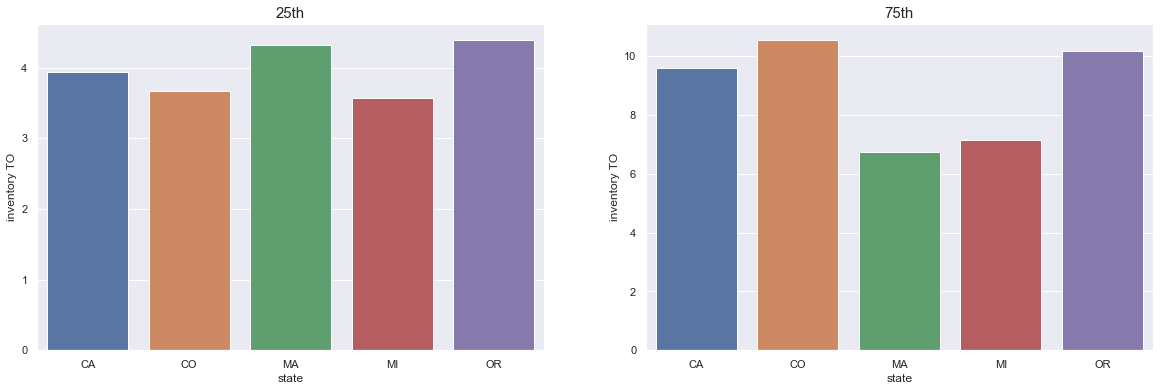

In [69]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="25%",ax=ax[0])

ax[0].set_title("25th", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="75%",ax=ax[1])

ax[1].set_title("75th", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



Text(0, 0.5, 'inventory TO')

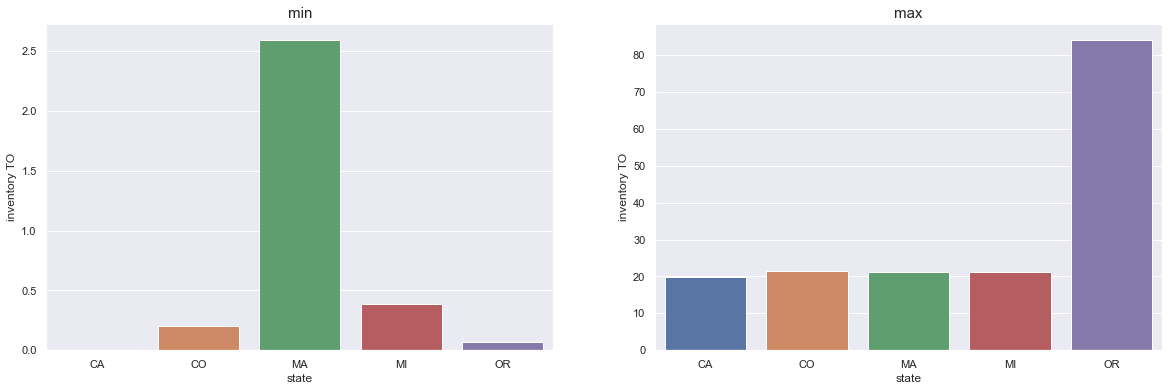

In [70]:
fig, ax =plt.subplots(1,2)
sns.barplot(data=to_distr, x="loc_state", y="min",ax=ax[0])

ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("state")
ax[0].set_ylabel ("inventory TO")
sns.barplot(data=to_distr, x="loc_state", y="max",ax=ax[1])

ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("state")
ax[1].set_ylabel ("inventory TO")



# product category analysis

In [ ]:
company_location_dataframes[1][3].groupby(['category']).apply(lambda x: x['reportUOM'].unique()).reset_index()

In [ ]:
company_location_dataframes[1][3][(company_location_dataframes[1][3]['category'] == 'PackedBud')&(company_location_dataframes[1][3]['reportUOM'] == 'Grams')]




In [ ]:
def pre_process_df_by_cat(df,loc_id,loc_state):
    
    df = (
        df
        .replace('None', np.nan).fillna(0)
        #.replace('None', np.nan)
        .assign(**{"uom_str": lambda df_: df_['reportUOM'].astype(str)})
        .assign(**{"uom": lambda df_: df_['uom_str'].str.lower()})
        .assign(**{"createdAt": lambda df_: pd.to_datetime(df_['createdAt'])})
        .assign(**{"year_month": lambda df_: df_['createdAt'].dt.strftime('%Y-%m')})
        .assign(**{"per_unit_price": lambda df_: df_['subtotalInDollars'] / df_['numberOfItems']})
        .assign(**{"per_unit_cost": lambda df_: df_['costInDollars'] / df_['numberOfItems']})
        #.replace('None', np.nan).fillna(0)
    )
    
    #exclude cost < $1.0
    df_low_cost = df[df['costInDollars'] < 1.0]
    df_non_low_cost = df[df['costInDollars'] >= 1.0]
    perc_low_cost = df_low_cost.shape[0] / df.shape[0]
    
    #exclude high unit sales price
    df_high_sale = df_non_low_cost[df_non_low_cost['per_unit_price'] > 500]
    df_non_high_sale =  df_non_low_cost[df_non_low_cost['per_unit_price'] <= 500]
    perc_high_sale = df_high_sale.shape[0] / df_non_low_cost.shape[0]
    
    #exclude high unit cost 
    #df_high_cost = df_non_high_sale[df_non_high_sale['per_unit_cost'] > 500]
    #df_non_high_cost =  df_non_high_sale[df_non_high_sale['per_unit_cost'] <= 500]
    #perc_high_cost = df_high_cost.shape[0] / df_non_high_sale.shape[0]
    
    # unit price & cost
    unit_med = df_non_high_sale[['year_month','category','uom','per_unit_price','per_unit_cost']].groupby(['year_month','category','uom']).median().reset_index()
    unit_mean = df_non_high_sale[['year_month','category','uom','per_unit_price','per_unit_cost']].groupby(['year_month','category','uom']).mean().reset_index()
    unit_mean.columns = ['year_month','category','uom','per_unit_price_mean','per_unit_cost_mean']
    unit = unit_med.merge(unit_mean, on = ['year_month','category','uom'],how = 'inner')
    unit['location_id'] = loc_id
    unit['location_state'] = loc_state

    return unit.reset_index()
    

In [ ]:
res_cat = []
for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
    if len(df) == 0:
        continue
    res_cat.append(pre_process_df_by_cat(df, location_id, location_state))

In [ ]:
final_df_cat = pd.concat(res_cat).reset_index(drop=True)

In [ ]:
final_df_cat[final_df_cat['category'] == 'PackedBud']['uom'].unique()

In [ ]:
# check UOM

In [ ]:
#company_location_dataframes[1][3][company_location_dataframes[1][3]['totalGramsSold'] != company_location_dataframes[1][3]['numberOfItems'] ]

In [ ]:
# def check_uom(df,loc_id,loc_state):
#     df = (
#         df.replace('None', np.nan)
#           #.dropna()
#           .assign(**{"uom_str": lambda df_: df_['reportUOM'].astype(str)})
#           .assign(**{"uom": lambda df_: df_['uom_str'].str.lower()})
#         #
#     )
#     uom_df = df.groupby(['category']).apply(lambda x: x['uom'].unique()).reset_index()
#     return uom_df
    

In [ ]:
# res_uom = []
# for company_id, location_id, location_state, df, inv_df in tqdm(company_location_dataframes):
#     if len(df) == 0:
#         continue
#     res_uom.append(check_uom(df, location_id, location_state))


In [ ]:
# res_uom_df = pd.concat(res_uom).reset_index(drop=True)
# res_uom_df

In [ ]:
# res_uom_df['category'].unique()

In [ ]:
# pb_uom = res_uom_df[res_uom_df['category'] == 'PackedBud'].reset_index(drop = True)
# pb_uom.columns = ['category','uom']
# pb_uom['uom'].apply(tuple).drop_duplicates()

## CA

In [ ]:
ca_cat = final_df_cat[final_df_cat['location_state'] == 'CA']
ca_cat['category'].unique()

In [ ]:
ca_pb.sort_values(by = 'per_unit_price',ascending = False)

In [ ]:
ca_cat[ca_cat['category'] == 'PackedBud']['uom'].unique()

In [ ]:
ca_acc = ca_cat[ca_cat['category'].isin(['Accessory'])]
ca_con = ca_cat[ca_cat['category'].isin(['Concentrate'])]
ca_edi = ca_cat[ca_cat['category'].isin(['Edible'])]
ca_pb = ca_cat[ca_cat['category'].isin(['PackedBud'])]
ca_tin = ca_cat[ca_cat['category'].isin(['Tincture'])]
ca_cap = ca_cat[ca_cat['category'].isin(['Capsule'])]
ca_top = ca_cat[ca_cat['category'].isin(['Topical'])]
ca_non_edi = ca_cat[ca_cat['category'].isin(['NonEdible'])]
ca_pat = ca_cat[ca_cat['category'].isin(['Patch'])]
ca_seed = ca_cat[ca_cat['category'].isin(['Seed'])]
ca_clone = ca_cat[ca_cat['category'].isin(['Clone'])]

ca_bb = ca_cat[ca_cat['category'].isin(['BulkBud'])]
ca_supp = ca_cat[ca_cat['category'].isin(['Suppository'])]
ca_ps = ca_cat[ca_cat['category'].isin(['PackedShake'])]

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(2,2)
sns.lineplot(data=ca_acc, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Accessory", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_con, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Concentrate", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Edible", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_pb[ca_pb['uom'].isin(['grams','each','35','0'])], x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("packedbud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")



In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(2,2)
sns.lineplot(data=ca_tin, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Tincture", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_cap, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Capsule", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_top, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Topical", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_non_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("Non Edible", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")



In [ ]:
sns.set(rc={'figure.figsize':(25,18)})
fig, ax =plt.subplots(3,2)
sns.lineplot(data=ca_pat, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Patch", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_seed, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Seed", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_clone, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Clone", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_bb, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("BulkBud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_supp, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,0])
ax[2,0].set_title("Suppository", fontsize=15)
ax[2,0].set_xlabel ("year month")
ax[2,0].set_ylabel ("per_unit_price")

sns.lineplot(data=ca_ps, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,1])
ax[2,1].set_title("PackedShake", fontsize=15)
ax[2,1].set_xlabel ("year month")
ax[2,1].set_ylabel ("per_unit_price")



## CO

In [ ]:
co_cat = final_df_cat[final_df_cat['location_state'] == 'CO']
co_cat['category'].unique()

In [ ]:
co_acc = co_cat[co_cat['category'].isin(['Accessory'])]
co_con = co_cat[co_cat['category'].isin(['Concentrate'])]
co_edi = co_cat[co_cat['category'].isin(['Edible'])]
co_pb = co_cat[co_cat['category'].isin(['PackedBud'])]
co_tin = co_cat[co_cat['category'].isin(['Tincture'])]
co_cap = co_cat[co_cat['category'].isin(['Capsule'])]
co_top = co_cat[co_cat['category'].isin(['Topical'])]
co_non_edi = co_cat[co_cat['category'].isin(['NonEdible'])]
co_pat = co_cat[co_cat['category'].isin(['Patch'])]
co_seed = co_cat[co_cat['category'].isin(['Seed'])]
co_clone = co_cat[co_cat['category'].isin(['Clone'])]

co_bb = co_cat[co_cat['category'].isin(['BulkBud'])]
co_supp = co_cat[co_cat['category'].isin(['Suppository'])]
co_ps = co_cat[co_cat['category'].isin(['PackedShake'])]

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(2,2)
sns.lineplot(data=co_acc, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Accessory", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_con, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Concentrate", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=co_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Edible", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_pb[co_pb['uom'].isin(['grams','each','0'])], x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("packedbud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")



In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(2,2)
sns.lineplot(data=co_tin, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Tincture", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_cap, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Capsule", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=co_top, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Topical", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_non_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("Non Edible", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")



In [ ]:
sns.set(rc={'figure.figsize':(25,18)})
fig, ax =plt.subplots(3,2)
sns.lineplot(data=co_pat, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Patch", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_seed, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Seed", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=co_clone, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Clone", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_bb, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("BulkBud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")

sns.lineplot(data=co_supp, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,0])
ax[2,0].set_title("Suppository", fontsize=15)
ax[2,0].set_xlabel ("year month")
ax[2,0].set_ylabel ("per_unit_price")

sns.lineplot(data=co_ps, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,1])
ax[2,1].set_title("PackedShake", fontsize=15)
ax[2,1].set_xlabel ("year month")
ax[2,1].set_ylabel ("per_unit_price")



## OR

In [ ]:
or_cat = final_df_cat[final_df_cat['location_state'] == 'OR']
or_cat['category'].unique()

In [ ]:
or_acc = or_cat[or_cat['category'].isin(['Accessory'])]
or_con = or_cat[or_cat['category'].isin(['Concentrate'])]
or_edi = or_cat[or_cat['category'].isin(['Edible'])]
or_pb = or_cat[or_cat['category'].isin(['PackedBud'])]
or_tin = or_cat[or_cat['category'].isin(['Tincture'])]
or_cap = or_cat[or_cat['category'].isin(['Capsule'])]
or_top = or_cat[or_cat['category'].isin(['Topical'])]
or_non_edi = or_cat[or_cat['category'].isin(['NonEdible'])]
or_pat = or_cat[or_cat['category'].isin(['Patch'])]
or_seed = or_cat[or_cat['category'].isin(['Seed'])]
or_clone = or_cat[or_cat['category'].isin(['Clone'])]

or_bb = or_cat[or_cat['category'].isin(['BulkBud'])]
or_supp = or_cat[or_cat['category'].isin(['Suppository'])]
or_ps = or_cat[or_cat['category'].isin(['PackedShake'])]

or_e = or_cat[or_cat['category'].isin(['Extract'])]
or_inf = or_cat[or_cat['category'].isin(['Infused'])]


In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(2,2)
sns.lineplot(data=or_acc, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Accessory", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_con, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Concentrate", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=or_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Edible", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_pb[or_pb['uom'].isin(['grams','each','0'])], x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("packedbud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")



In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
fig, ax =plt.subplots(3,2)
sns.lineplot(data=or_tin, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Tincture", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_cap, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Capsule", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=or_top, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Topical", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_non_edi, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("Non Edible", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")


sns.lineplot(data=or_e, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,0])
ax[2,0].set_title("Extract", fontsize=15)
ax[2,0].set_xlabel ("year month")
ax[2,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_inf, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,1])
ax[2,1].set_title("Infused", fontsize=15)
ax[2,1].set_xlabel ("year month")
ax[2,1].set_ylabel ("per_unit_price")


In [ ]:
sns.set(rc={'figure.figsize':(25,18)})
fig, ax =plt.subplots(3,2)
sns.lineplot(data=or_pat, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,0])
ax[0,0].set_title("Patch", fontsize=15)
ax[0,0].set_xlabel ("year month")
ax[0,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_seed, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[0,1])
ax[0,1].set_title("Seed", fontsize=15)
ax[0,1].set_xlabel ("year month")
ax[0,1].set_ylabel ("per_unit_price")

sns.lineplot(data=or_clone, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,0])
ax[1,0].set_title("Clone", fontsize=15)
ax[1,0].set_xlabel ("year month")
ax[1,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_bb, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[1,1])
ax[1,1].set_title("BulkBud", fontsize=15)
ax[1,1].set_xlabel ("year month")
ax[1,1].set_ylabel ("per_unit_price")

sns.lineplot(data=or_supp, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,0])
ax[2,0].set_title("Suppository", fontsize=15)
ax[2,0].set_xlabel ("year month")
ax[2,0].set_ylabel ("per_unit_price")

sns.lineplot(data=or_ps, x="year_month", y="per_unit_price", hue="uom",marker= 'o', markersize=9,ax=ax[2,1])
ax[2,1].set_title("PackedShake", fontsize=15)
ax[2,1].set_xlabel ("year month")
ax[2,1].set_ylabel ("per_unit_price")

